# Building a Chatbot
## Part I: Search and Retrieval

### CORE Studio, Thornton Tomasetti

#### Instructor: [Seyedomid Sajedi](https://www.linkedin.com/in/seyedomid-sajedi-263b703a)

In this exercise, we will explore Retrieval Augmented Generation (RAG) and delve into prompt engineering for large language models. Our objective is to understand how to use these models effectively for Question-Answering (QA) tasks on custom datasets.

This notebook represents the first step in a three-part process of creating an interactive chatbot:

* Part I: Search and Retrieval
* Part II: Prompt Engineering
* Part III: Building a Chatbot UI

In Parts I and II, we will break down the key components of our custom bot. In Part III, we will integrate these components into a chatbot with a user-friendly interface. Let's get started!


---

#Libraries

In [1]:
%%capture
!pip install rank_bm25 pypdf2 tiktoken

In [1]:
# https://spacy.io/
import spacy
# !pip install --upgrade spacy # might be needed if the default spacy in colab is not working
import requests
from io import BytesIO
from PyPDF2 import PdfReader
from tqdm import tqdm
import tiktoken
import pickle

## spaCy
[spaCy](https://spacy.io/) is a popular and powerful natural language processing (NLP) library that excels in tasks like tokenization, part-of-speech tagging, named entity recognition. Its efficiency and pre-trained models make it a great choice for developers, researchers, and businesses looking to work with text data, enabling them to quickly and accurately analyze and extract insights from large amounts of text, with support for multiple languages and a user-friendly API.

We will use spaCy's tokenization for our exercise but it also comes with other useful features as well that we will quickly take a look at.



It is a good idea to remove english stop words from our tokenization.

In [2]:
nlp_model = spacy.load("en_core_web_sm")
# Get the list of stop words
stop_words = list(nlp_model.Defaults.stop_words)
print(len(stop_words))
print(stop_words)

326
['from', 'together', 'became', 'too', '’ll', 'one', 'whoever', 'thru', 'elsewhere', 'top', 'must', 'anyway', 'she', 'meanwhile', 'seems', 'at', 'thereupon', 'do', 'just', 'much', 'last', 'perhaps', 'for', 'somehow', 'some', 'who', 'the', 'otherwise', "'ve", 'themselves', 'latter', 'to', 'were', 'fifty', '‘ve', 'whence', 'ever', 'him', 'wherever', 'my', 'have', 'noone', 'via', 'never', 'n‘t', 'beyond', 'sometime', 'forty', 'these', 'per', 'own', 'few', 'what', 'among', 'above', 'that', 'mine', 'than', "'ll", 'doing', 'does', 'being', 'here', 'yourselves', 'they', 'until', 'an', 'another', 'yours', 'throughout', 'keep', 'you', 'many', 'still', 'any', "'re", 'thereafter', 'seem', 'its', 'whereas', '‘m', 'latterly', 'such', 'all', 'therefore', 'hereupon', 'besides', 'hereby', 'even', 'been', 'none', 'always', "'s", 'during', 'formerly', 'i', 'every', 'although', 'wherein', 'take', 'say', 'enough', 'bottom', 'five', 'across', 'four', 'others', 'a', 'somewhere', 'has', 'please', 'two', '

spaCy will convert a string into a document object that contains lots of interesting information. Not everything done by spaCy is based on ML. It knows the langauge grammar very well.

In [4]:
text = """
           ExxonMobil Infrastructure Development Proposal
            Executive Summary:
            This comprehensive proposal envisions the construction of ExxonMobil's new operational hub, designed to bolster its strategic expansion and operational excellence within the energy sector.
            Introduction:
            We propose to construct a state-of-the-art facility that reflects ExxonMobil's commitment to innovation, sustainability, and global leadership in energy. The project will span a meticulously selected 35,000-square-foot site in Houston, Texas, with the potential to become a landmark of industrial prowess and architectural ingenuity.
            Project Team:
            Leading the project will be Chief Project Engineer, Thomas Booker, with over two decades of experience in industrial construction. Architectural design will be spearheaded by Ava Clarke, whose portfolio includes several LEED-certified buildings across Dallas. Our environmental engineering efforts will be led by Dylan Rhodes in Austin, ensuring adherence to the most stringent ecological standards.
            Site and Structure:
            The facility will be located in the heart of Houston’s Energy Corridor, taking advantage of the area's rich infrastructure and proximity to ExxonMobil’s main operations. Geotechnical assessments and site preparation will be undertaken by San Antonio-based expert, Nora Quintana. The building's framework, designed for resilience and adaptability, will be overseen by structural engineer Alex Johnson from Fort Worth.
            Sustainability and Environment:
            Sustainability Coordinator, Rachel Santos from Corpus Christi, will implement cutting-edge green technologies, including a state-of-the-art HVAC system designed by El Paso's mechanical engineer, Omar Fernandez. Rainwater harvesting and waste management systems will be developed in collaboration with environmental specialists from Galveston 
            Email address: test@gmail.com
            123-456-7890
            """
doc = nlp_model(text)

For example, it can visualize Parts of Speech (POS):

In [5]:
spacy.displacy.render(doc, style="dep", jupyter=True)

Or tag entities in your text:

In [5]:
spacy.displacy.render(doc, style="ent", jupyter=True)

We will use spaCy to tokenize both reference documents in our database and user search queries. The following function handles tokenization for us:

In [9]:
def spacy_tokenizer(text, nlp):
    doc = nlp(text)
    tokens = []
    for token in doc:
        # Check if the token is not punctuation and not a stop word
        if not (token.is_punct or token.is_stop):
            tokens.append(token.lemma_.lower())
    return tokens

The following cell shows how our function converts a string into a list of tokens. Note that stop workds are removed and words are [lemmatized](https://en.wikipedia.org/wiki/Lemmatization) to enahce our search.

**Important note!**

Keep in mind that these tokens are different from the tokens used by an LLM like ChatGPT. We will see the difference in the next exercise.

In [10]:
print(spacy_tokenizer(text,nlp_model))

['attend', 'workshop', 'chicago', 'downtown', 'october', '19th', '$', '5', 'million', 'dollar', 'month', 'buy', '2000', 'square', 'foot', 'penthouse', '120', 'broadway', 'manhattan']


In [12]:
test_prompt="Hello! My name is Silvester Stalone"
openai_tokenizer = tiktoken.get_encoding("cl100k_base")
llm_tokens = openai_tokenizer.encode(test_prompt)
print(f'Token indices: {llm_tokens}')
decoded_tokens = openai_tokenizer.decode(llm_tokens)
print(decoded_tokens)
for token in llm_tokens:
  token_str = str(openai_tokenizer.decode_single_token_bytes(token),encoding='utf-8')
  print(f"token_indx: {token}: {token_str}")

Token indices: [9906, 0, 3092, 836, 374, 8211, 83838, 800, 32676]
Hello! My name is Silvester Stalone
token_indx: 9906: Hello
token_indx: 0: !
token_indx: 3092:  My
token_indx: 836:  name
token_indx: 374:  is
token_indx: 8211:  Sil
token_indx: 83838: vester
token_indx: 800:  St
token_indx: 32676: alone


The next function will grab a pdf document from a url and loads it into memory. You can alternatively upload a document to Colab or your working directory and load it manually.

In [13]:
# We used this function for topic modeling
def get_pdf_as_memory_stream(url):
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for HTTP errors
    # Convert the response content into a BytesIO stream
    return BytesIO(response.content)

For our chatbot, we leverage a public document called [Local law 77 of NYC for the year of 2023](r"https://www.nyc.gov/assets/buildings/local_laws/ll77of2023.pdf"). Feel free to check out NYC's building codes from [this](https://www.nyc.gov/site/buildings/codes/2022-construction-codes.page#bldgs) website.

In [14]:
pdf_url = r"https://www.nyc.gov/assets/buildings/local_laws/ll77of2023.pdf"
pdf_file = get_pdf_as_memory_stream(pdf_url)

Loading a pdf file and extracting pages is very similar to what we did in exercise 2.

In [15]:
reader = PdfReader(pdf_file)
# number of pages
n_pages = len(reader.pages)
print(f"Number of pages: {n_pages}")

Number of pages: 184


In [17]:
page = reader.pages[0]
print(page.extract_text())

LOCAL LAWS  
OF 
THE CITY OF NEW YORK  
FOR THE YEAR 202 3 
 
______________________  
 
No. 77 
_______________ __ 
 
Introduced b y Council Members Sanchez, Louis , Mealy  and the Public Advocate (Mr. Williams) 
(by request of the Mayor) . 
 
A LOCAL LAW  
 
To amend the administrative code of the city of New York, the New York city plumbing code, 
the New York city building code, the New York city mechanical code and the New York 
city fuel gas code, in relation to technical corrections, clarifications and modifications to 
provisions of the New York city construction codes  
 
Be it enacted by the Council as follows:  
Section 1. The definition of “CHARTER” set forth in section 28 -101.5 of the administrative 
code of the city of New York, as amended by local law number 126 for the year 2021, shall be 
ordered in alphabetical order.  
 
§ 2. The definitions of “ LIMITED ALTERA TION APPLICATION,” “LIMITED OIL -
BURNING APPLIANCE ALTERATIONS,” “LIMITED PLUMBING ALTERATIONS,” and 
“MA

## Indexing the search database
Large language models have a limit cap on the amount of text they can handle for each conversation. We have to keep that in mind when building our search databse. It is ideal to chunk your long documents into small and independent sections. This smart chunking, however, could be very challenging to automate for large datasets. It is also important to keep the chunks roughly the same size. Having very long and very short chunks could adversly affect the quality of search.

For this exercise, we will simply split the document page by page. In a real project, it is often worth spending on a more delibrate strategy to index and chunk your text dataset.

In [18]:
# tokenize dataset
tokenized_dataset= []
text_dataset =[]
for page in tqdm(reader.pages,total=n_pages):
  text = page.extract_text()
  text_dataset.append(text)
  tokenized_page = spacy_tokenizer(text,nlp_model)
  tokenized_dataset.append(tokenized_page)

100%|██████████| 184/184 [00:28<00:00,  6.55it/s]


In [19]:
print(tokenized_dataset[0])

['local', 'law', ' \n', '\n', 'city', 'new', 'york', ' \n', 'year', '202', '3', '\n \n', ' \n \n', '77', '\n', '\n \n', 'introduce', 'b', 'y', 'council', 'members', 'sanchez', 'louis', 'mealy', ' ', 'public', 'advocate', 'mr.', 'williams', '\n', 'request', 'mayor', '\n \n', 'local', 'law', ' \n \n', 'amend', 'administrative', 'code', 'city', 'new', 'york', 'new', 'york', 'city', 'plumbing', 'code', '\n', 'new', 'york', 'city', 'building', 'code', 'new', 'york', 'city', 'mechanical', 'code', 'new', 'york', '\n', 'city', 'fuel', 'gas', 'code', 'relation', 'technical', 'correction', 'clarification', 'modification', '\n', 'provision', 'new', 'york', 'city', 'construction', 'code', ' \n \n', 'enact', 'council', 'follow', ' \n', 'section', '1', 'definition', 'charter', 'set', 'forth', 'section', '28', '-101.5', 'administrative', '\n', 'code', 'city', 'new', 'york', 'amend', 'local', 'law', 'number', '126', 'year', '2021', 'shall', '\n', 'order', 'alphabetical', 'order', ' \n \n', '2', 'defin

## Search Algorithm
Search algorithms play a pivotal role in various fields. Their complexity stems from the need to efficiently navigate vast datasets or solution spaces, making them indispensable tools for finding relevant information and optimizing decision-making processes in the modern world. For our search engine, we will utilize a classical and popular ranking model called [BM25](https://en.wikipedia.org/wiki/Okapi_BM25).

**Note:**

BM25 is a keyword sensitive (lexical) search algorithm. It calculates a relavance score between a given user query and reference documents. Does this sound familiar to anything we did befin the previous exercises?

In [21]:
from rank_bm25 import BM25Okapi
def init_bm25_vectorizer():
    return BM25Okapi(tokenized_dataset)
bm25_vectorizer = init_bm25_vectorizer()

In [22]:
# search
query="What are requirements for fire protective design?"
query_tokens = spacy_tokenizer(query,nlp_model)
query_tokens

['requirement', 'fire', 'protective', 'design']

In [23]:
bm25_scores = bm25_vectorizer.get_scores(query_tokens)
print(bm25_scores.shape)

(184,)


Let's do some visualization:

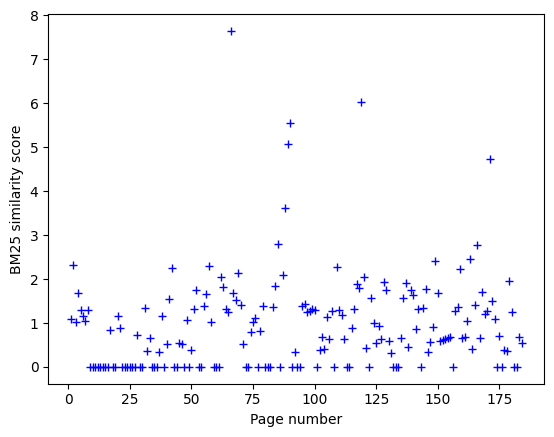

In [24]:
import matplotlib.pyplot as plt
import numpy as np
fig,ax = plt.subplots()
ax.plot(np.arange(n_pages)+1,bm25_scores,'+b')
ax.set_xlabel('Page number')
ax.set_ylabel('BM25 similarity score')
plt.show()
plt.close()

After scoring the documents based on relevance, they can be sorted to get the top k results.

In [25]:
top_k = 3 # Number of top k pages based on BM25 score
top_page_indx= np.argsort(bm25_scores)[-top_k:][::-1]
hits = [{'page_indx': idx, 'score': bm25_scores[idx]} for idx in top_page_indx]
hits

[{'page_indx': 65, 'score': 7.647716570593162},
 {'page_indx': 118, 'score': 6.031789574415344},
 {'page_indx': 89, 'score': 5.541819314445931}]

Now, let's print the retrieved documents:

In [26]:
for hit in hits:
  page_str = text_dataset[hit['page_indx']]
  openai_tokenizer = tiktoken.get_encoding("cl100k_base")
  token_count = len(openai_tokenizer.encode(page_str))
  print(f"PAGE: {hit['page_indx']+1}, token count:{token_count}")
  print(page_str)
  print("-"*50)

PAGE: 66, token count:647
66 
  
§ 126. Section 510 of the New York city building code, as renumbered by local law number 141 
for the year  2013, is amended to read as follows:  
SECTION BC 510  
SPECIAL PROVISIONS  
 
510.1 General.  The provisions in [ this section ]Sections 510.2 through 510.10  shall permit the use of 
special conditions that are exempt from, or modify, the specific requirements of t his chapter regarding 
the allowable building  heights and areas of buildings based on the occupancy classification and type 
of construction, provided the special condition complies with the provisions specified in this section 
for such condition and other a pplicable requirements of this code. The provisions of Sections 510.2 
through 510.8 are to be considered independent and separate from each other.  
510.2 Horizontal building separation allowance.  Buildings shall be considered as separate and 
distinct from e ach other for the purpose of determining area limitations, continuit

Finally we can create a clean function for our document retrieval:

In [ ]:
def doc_retrieval(query,
                  top_k=3):
  #  we need to load bm25_vectorizer,nlp_model in other scripts
  query_tokens = spacy_tokenizer(query,nlp_model)
  bm25_scores = bm25_vectorizer.get_scores(query_tokens)
  top_page_indx= np.argsort(bm25_scores)[-top_k:][::-1]
  hits = [{'page_indx': idx, 'score': bm25_scores[idx]} for idx in top_page_indx]
  return hits

In [ ]:
doc_retrieval('What are some recommendations for fire barrier design?')